In [1]:
import os
import scipy.signal as sp
%matplotlib inline
# import nbimporter
import sys  

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


## Load Calibration Data

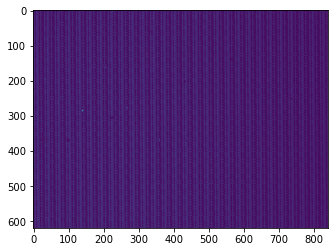

torch.Size([620, 840, 45])


In [2]:
# load filter calibration
datafolder = '../Calibration_Data'
fname = 'filterCal_every2nm_darksub_2021-02-03.mat'
(wv,ci,filterstack) = sdc.importFilterStack(datafolder,fname)

ci2 = [ci[0]-1, ci[1]-1,ci[2],ci[3]]

# decide wavelength sampling
wvmin = 450
wvmax = 800
wvstep = 8
wvnew = np.arange(wvmin,wvmax+wvstep,wvstep)
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)

#normalize the filter array
msum = msum/np.amax(msum)

#set up torch variables
m = torch.tensor(msum)
(dim0,dim1,dim2) = m.shape

plt.figure()
plt.imshow(torch.sum(m,axis=2))
#plt.colorbar()
plt.show()

print(m.shape)


[NY,NX,NL] = m.shape

torch.Size([620, 840])


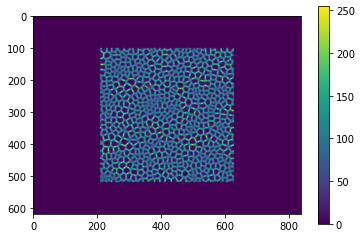

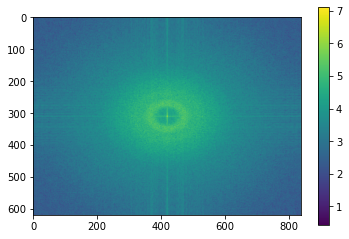

In [4]:
# load psf
datafolder = '../Calibration_Data'
# ACTION: choose psf file here
fname = 'psf_090_1.png'
# change the above two lines
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))
h = sdc.pad(psf)  # pad the psf
h = h[110:730,:] # make the same size as calibration data.
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

# padh = sdc.pad2d(h)  # pad the psf  (to help with the shifting?)
# compute the FFT
Hfft = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(Hfft)))
plt.colorbar()

In [59]:
# create a gaussian point
class GaussObject:
    def __init__(self, muy = 0.0, mux = 0.0, mul = 0.0, sigy =1.0, sigx = 1.0, sigl = 1.0, amp = 1.0): #TODO: add more parameters
        self.initParams(muy,mux,mul,sigy,sigx,sigl, amp)

    def initParams(self,muy,mux,mul,sigy,sigx,sigl, amp): # only used at initialization
        self.mux = torch.tensor(mux,requires_grad = True)
        self.muy = torch.tensor(muy,requires_grad = True)
        self.mul = torch.tensor(mul,requires_grad = True)
        self.sigx = torch.tensor(sigx,requires_grad = True)
        self.sigy = torch.tensor(sigy,requires_grad = True)
        self.sigl = torch.tensor(sigl,requires_grad = True)
        self.covariancematrix = torch.tensor([[sigy**2, 0.0], [0.0, sigx**2]], requires_grad=True)
        self.amplitude = torch.tensor(amp,requires_grad = True)

    def __str__(self):
        return f"GaussObject(mu_x = {self.mux}, mu_y = {self.muy}, mu_l = {self.mul}), cov = {self.covariancematrix}"
    
    def computeValues(self, coordinates,ny,nx):
        mvn = MultivariateNormal(torch.Tensor([self.muy,self.mux]), self.covariancematrix)
        pdf_values = mvn.log_prob(coordinates).exp() * self.amplitude
        pdf_values = pdf_values.view(ny, nx) 
        return pdf_values

    def plot(self,coordinates, ny, nx):
        pdf_values = self.computeValues(coordinates, ny, nx)
        plt.figure()
        plt.imshow(pdf_values.detach().numpy())
        plt.colorbar()
        plt.xlabel('X')
        plt.ylabel('Y')

    def gradStep(self,learningrate):
        self.mux.data = self.mux.data - learningrate[0]*self.mux.grad.data
        self.muy.data = self.muy.data - learningrate[1]*self.muy.grad.data
        self.mul.data = self.mul.data - learningrate[2]*self.mul.grad.data
        self.covariancematrix.data = self.covariancematrix.data - learningrate[3]*self.covariancematrix.grad.data
        self.sigl.data = self.sigl.data - learningrate[4]*self.sigl.grad.data
        self.amplitude.data = self.amplitude.data - learningrate[5]*self.amplitude.grad.data

    def zeroGrad(self):
        self.mux.grad.data.zero_()
        self.muy.grad.data.zero_()
        self.mul.grad.data.zero_()
        self.sigl.grad.data.zero_()
        self.amplitude.grad.data.zero_()
        self.covariancematrix.grad.data.zero_()

g1 = GaussObject()
print(g1)
g1.initParams(1.0,1.0,1.0,1.0,1.0,1.0, 1.0)
print(g1)

GaussObject(mu_x = 0.0, mu_y = 0.0, mu_l = 0.0), cov = tensor([[1., 0.],
        [0., 1.]], requires_grad=True)
GaussObject(mu_x = 1.0, mu_y = 1.0, mu_l = 1.0), cov = tensor([[1., 0.],
        [0., 1.]], requires_grad=True)


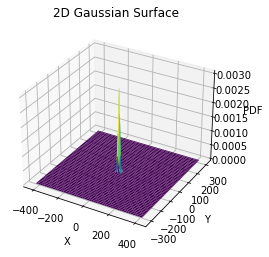

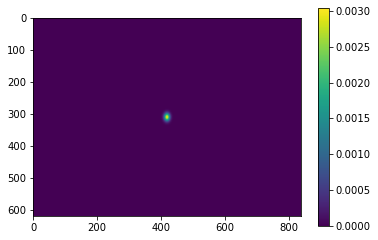

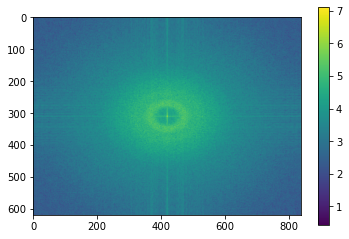

In [47]:
# Set the mean and covariance matrix for the Gaussian distribution

xpixwidth = 10
ypixwidth = 10
# covariance_matrix = torch.tensor([[ypixwidth**2, 0.0], [0.0, xpixwidth**2]])
g1.initParams(1.0,1.0,1.0,100.0,100.0,1.0,1e0)
covariance_matrix = g1.covariancematrix
sigy = g1.sigy
sigx = g1.sigx

amplitude = g1.amplitude

def createMeshGrid(nx,ny):  
    # Create a 2D grid
    y, x = torch.meshgrid(torch.linspace(-ny/2, ny/2, ny), torch.linspace(-nx/2, nx/2, nx), indexing="ij" )  #[y,x]
    x.requires_grad_(False)
    y.requires_grad_(False)
    # Flatten the grid to obtain coordinates for evaluation
    coordinates = torch.stack([y.flatten(), x.flatten()], dim=1)  # mvn is y then x also
    return [x,y, coordinates]

[x,y,coordinates] = createMeshGrid(NX,NY)

def createGaussFilter(cov_matrix, coordinates,nx,ny, amplitude, sf = 1e-8):
    mean = torch.tensor([0.0, 0.0])
    scaleFactor = torch.tensor([[sf*nx**2, 0.0],[  0.0, sf*ny**2]])
    filterVar = torch.matmul(scaleFactor,cov_matrix)
    filterVar = (filterVar + filterVar.t()) / 2.0  # ensure that it's positive-definite

    # Create a MultivariateNormal distribution
    mvn = MultivariateNormal(mean, filterVar)
    # Evaluate the PDF at each point in the grid
    pdf_values = mvn.log_prob(coordinates).exp() * amplitude #TODO: maybe replace with my own implementation so I can be sure of the scaling? 
    pdf_values = pdf_values.view(ny, nx) # doesn't work the other way
    return pdf_values

pdf_values = createGaussFilter(covariance_matrix, coordinates, NX,NY, amplitude)
# normalize for now
# pdf_values = pdf_values/torch.amax(pdf_values)

# Plot the 2D Gaussian surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), torch.abs(pdf_values).detach().numpy(), cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('2D Gaussian Surface')

plt.show()

plt.figure()
plt.imshow((torch.abs(pdf_values).detach().numpy()))
plt.colorbar()
# plt.figure()
# plt.imshow(torch.angle(pdf_values).detach().numpy())
# plt.colorbar()

bfft = torch.mul(Hfft, pdf_values)
bout = torch.fft.ifft2(torch.fft.fftshift(bfft))
plt.figure()
plt.imshow(torch.log10(torch.abs(Hfft)).detach().numpy())
plt.colorbar()

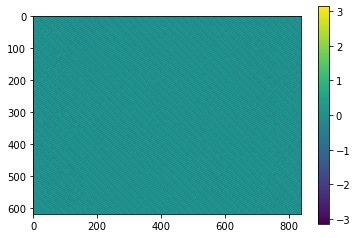

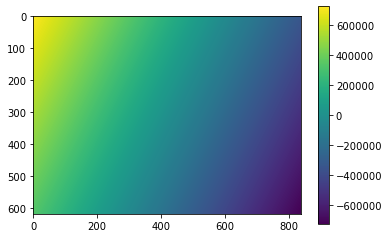

In [48]:
# also add phase shift based on position. 
# phase shift is based on phi = kn*(x0)

xshift = 200
yshift = 100

def createPhasor(x,y, xshift,yshift):
    freq_x = xshift # Adjust this value to control the frequency of the phase ramp
    freq_y = yshift

    phase_ramp =  2.0 * torch.pi * (-1*(freq_x * x) - (freq_y * y))
    phasor = torch.exp(1j*phase_ramp)
    return (phasor, phase_ramp)

(phasor, phase_ramp) = createPhasor(x,y,xshift,yshift)

plt.figure()
plt.imshow(torch.angle(phasor).detach().numpy())
plt.colorbar()

plt.figure()
plt.imshow((phase_ramp).detach().numpy())
plt.colorbar()

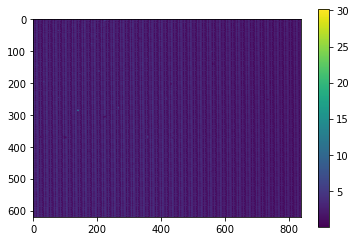

In [49]:
# create a guassian with center mul and width sigl
lam = torch.arange(0,NL)
mul = 5
sigl = 150
def createWVFilt(lam, mul, sigl,m):
    gaus_lam = torch.exp(-(lam-mul)**2/(2*sigl**2))
    mout = torch.sum(torch.mul(m,gaus_lam), dim=2)
    return mout
mout = createWVFilt(lam,mul,sigl,m)
plt.imshow(mout)
plt.colorbar()

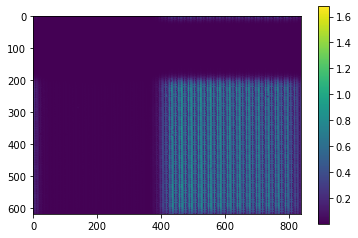

In [50]:
# try multiplying and seeing the output. 

def computeMeas(Hfft,pdf_values,phasor, mout):
    bfft = torch.mul(Hfft, pdf_values)
    bfft2 = torch.mul(bfft,phasor)
    bout = torch.fft.ifft2(torch.fft.fftshift(bfft2))
    b = torch.mul(torch.abs(bout),mout) # TODO: figure out why the abs is needed. i.e. why it's becoming negative with certain phaseramps. Maybe aliasing?
    return b
b = computeMeas(Hfft,pdf_values,phasor,mout)
plt.imshow(((torch.abs(b)).detach().numpy()))
plt.colorbar()

## Now combine with gauss object

GaussObject(mu_x = 1.0, mu_y = 1.0, mu_l = 5.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)


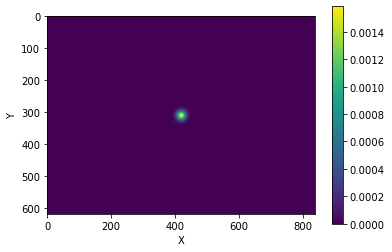

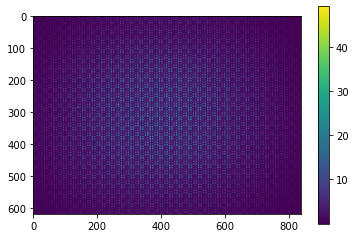

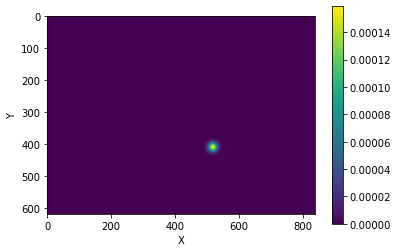

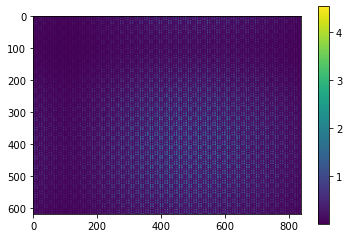

In [52]:
[x,y,coordinates] = createMeshGrid(NX,NY)  
lam = torch.arange(0,NL)
g1 = GaussObject()
g1.initParams(1.0,1.0,5.0,10.0,10.0,5.0,1.0) # make sure all are floating
print(g1)
g1.plot(coordinates,NY,NX)

# forward model for each gauss object

def forwardSingleGauss(g, coordinates, nx,ny, lam, Hfft,x,y,m):
    pdf_values = createGaussFilter(g.covariancematrix, coordinates, nx,ny, g.amplitude)
    (phasor,phase_ramp) = createPhasor(x,y,g.mux,g.muy)
    mout = createWVFilt(lam,g.mul,g.sigl,m)
    b = computeMeas(Hfft,pdf_values,phasor,mout)
    return b

b = forwardSingleGauss(g1, coordinates, NX, NY, lam, Hfft,x,y,m)
plt.figure()
plt.imshow(b.detach().numpy())
plt.colorbar()
plt.show()

g2 = GaussObject()
g2.initParams(100.0,100.0,5.0,10.0,10.0,5.0,1e-1) # make sure all are floating
g2.plot(coordinates,NY,NX)
b2 = forwardSingleGauss(g2, coordinates, NX, NY, lam, Hfft,x,y,m)

plt.figure()
plt.imshow(b2.detach().numpy())
plt.colorbar()
plt.show()

## A whole bunch of gaussians

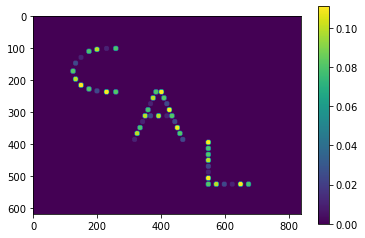

torch.Size([1240, 1680])


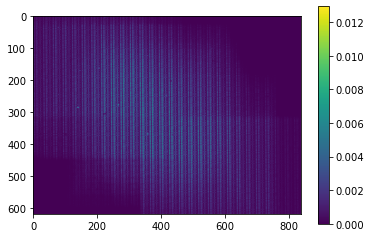

In [53]:
# load some measurements

datafolder = '../Sample_Objects/'
fname = 'cal_marbles.npy' # cal_beads_numpy_array
cal_beads = torch.from_numpy(np.load(os.path.join(datafolder, fname)))
plt.figure()
plt.imshow(cal_beads[:,:,0])
plt.colorbar()
# plt.colorbar()
plt.show()

# set up H matrix for convolution
hcal = sdc.pad(psf)  # pad the psf
hcal = sdc.pad(hcal)
hcal = hcal[220:1460,:]
print(hcal.shape)
hcal = sdc.make3d(hcal,dim2) # permute along dim 2
hcal = sdc.fft3d(hcal) # take fft along dim 0 and 1

bm = sdc.forwardmodel3d(sdc.pad(cal_beads), hcal, m)
bm = bm/torch.norm(bm) # normalize
plt.figure()
plt.imshow(bm)
plt.colorbar()
plt.show()

<ipython-input-59-2db038e117a7>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mux = torch.tensor(mux,requires_grad = True)
<ipython-input-59-2db038e117a7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.muy = torch.tensor(muy,requires_grad = True)
<ipython-input-59-2db038e117a7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mul = torch.tensor(mul,requires_grad = True)


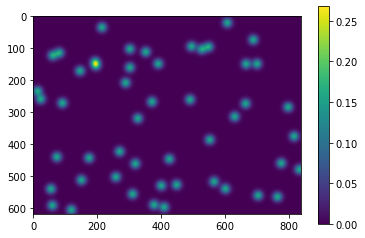

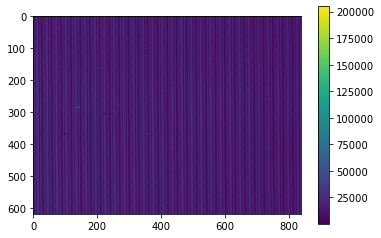

In [60]:
# initialize the gaussians

K = 50  # sparsity level

means_initxy = torch.rand(K, 2)  # Uniformly sampled points in a 2D space
vars_initxy = 10.0
means_initlam = torch.rand(K,1) * NL
vars_initlam = 5.0
amp_init = 1e2
# randomize the mean position; create a torch vector of [50,2] uniform sampled
beads = [] # empty list of gauss objects
# create gaussian objects with those means
meas = torch.zeros_like(h) 
obj = torch.zeros_like(h)
for k in np.arange(K):
    beads.append(GaussObject(means_initxy[k,0]*NY - NY/2, means_initxy[k,1]*NX- NX/2, means_initlam[k], vars_initxy, vars_initxy, vars_initlam, amp_init))
    obj = obj + beads[k].computeValues(coordinates, NY, NX)
    b = forwardSingleGauss(beads[k], coordinates, NX, NY, lam, Hfft,x,y,m)  # compute individual measurements
    meas = meas + b # add them together
    # print(k)

plt.figure()
plt.imshow(obj.detach().numpy())
plt.colorbar()
plt.figure()
plt.imshow(meas.detach().numpy())
plt.colorbar()

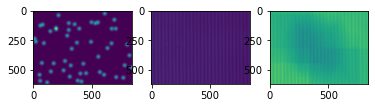

Gradient mux:  tensor(0.0674)
Gradient muy:  tensor(0.0238)
Gradient mul:  tensor([0.0010])
Gradient sigx:  None
Gradient sigy:  None
Gradient sigl:  tensor(0.0005)
Gradient cov:  tensor([[-2.9120e-05,  2.1901e-05],
        [ 1.1931e-05, -9.6297e-06]])


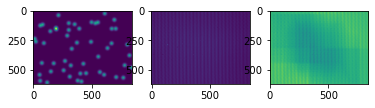

Gradient mux:  tensor(0.0294)
Gradient muy:  tensor(0.0115)
Gradient mul:  tensor([0.0007])
Gradient sigx:  None
Gradient sigy:  None
Gradient sigl:  tensor(1.3809e-05)
Gradient cov:  tensor([[-1.4291e-05,  2.0224e-05],
        [ 1.1018e-05, -7.8640e-06]])


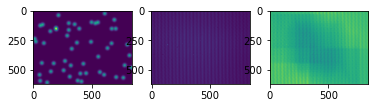

Gradient mux:  tensor(0.0254)
Gradient muy:  tensor(0.0109)
Gradient mul:  tensor([0.0007])
Gradient sigx:  None
Gradient sigy:  None
Gradient sigl:  tensor(-8.0041e-05)
Gradient cov:  tensor([[-1.4081e-05,  2.3354e-05],
        [ 1.2723e-05, -8.9995e-06]])


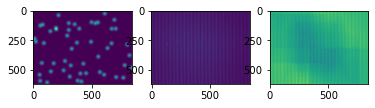

Gradient mux:  tensor(0.0210)
Gradient muy:  tensor(0.0101)
Gradient mul:  tensor([0.0008])
Gradient sigx:  None
Gradient sigy:  None
Gradient sigl:  tensor(-0.0001)
Gradient cov:  tensor([[-1.4182e-05,  2.5515e-05],
        [ 1.3900e-05, -9.9793e-06]])


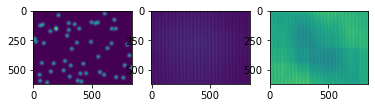

Gradient mux:  tensor(0.0168)
Gradient muy:  tensor(0.0092)
Gradient mul:  tensor([0.0008])
Gradient sigx:  None
Gradient sigy:  None
Gradient sigl:  tensor(-0.0002)
Gradient cov:  tensor([[-1.4673e-05,  2.6947e-05],
        [ 1.4680e-05, -1.0829e-05]])


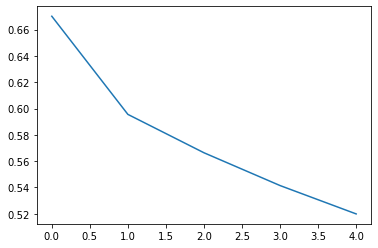

In [62]:
lr = [1, 1, 1e-2, 1e-2, 1e-2, 1e-2] # mux, muy, mul, cov, sigl, amp
iterations = 5
loss_GD = []

# normalize the measurement


for k2 in range(iterations):
    # compute forward model
    best = torch.zeros_like(h)
    for k in np.arange(K):
        best =  best + forwardSingleGauss(beads[k], coordinates, NX, NY, lam, Hfft,x,y,m)  # compute individual measurements
#         obj = obj + beads[k].computeValues(coordinates, NY, NX)

    best = best/torch.norm(best)
    # plot the beads
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(obj.detach().numpy())
    plt.subplot(1,3,2)
    plt.imshow(best.detach().numpy())
    plt.subplot(1,3,3)
    plt.imshow((best-bm).detach().numpy())
    plt.show()
    
    # compute loss
    loss = torch.norm(best - bm)
    loss_GD.append(loss.item())
    loss.backward()
    print("Gradient mux: ", beads[0].mux.grad)
    print("Gradient muy: ", beads[0].muy.grad)
    print("Gradient mul: ", beads[0].mul.grad)
    print("Gradient sigx: ", beads[0].sigx.grad)
    print("Gradient sigy: ", beads[0].sigy.grad)
    print("Gradient sigl: ", beads[0].sigl.grad)
    print("Gradient cov: ", beads[0].covariancematrix.grad)

    # update gaussian parameters
    for k in range(K):
        beads[k].gradStep(lr)
        beads[k].zeroGrad()
plt.figure()
plt.plot(loss_GD)       
    

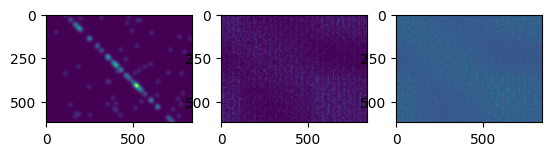

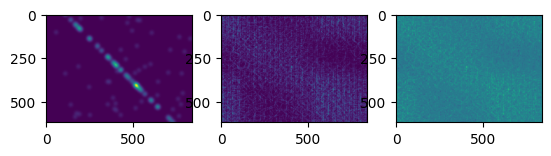

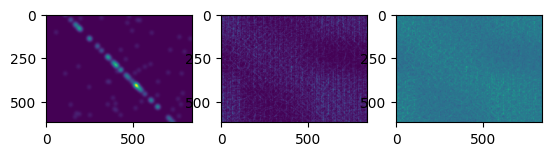

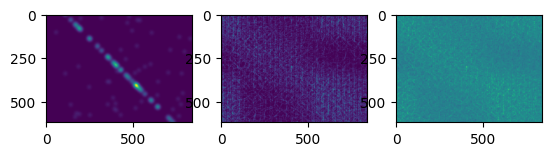

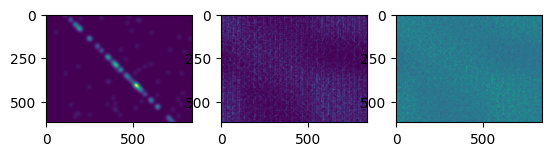

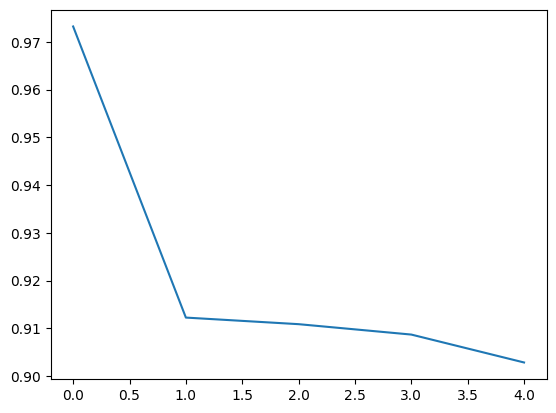

In [ ]:
# try to go with another measuremetn
lr = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2] # mux, muy, mul, cov, sigl, amp
iterations = 5
loss_GD2 = []

# normalize the measurement

for k2 in range(iterations):
    # compute forward model
    best = torch.zeros_like(h)
    for k in np.arange(K):
        best =  best + forwardSingleGauss(beads[k], coordinates, NX, NY, lam, Hfft,x,y,m)  # compute individual measurements
        obj = obj + beads[k].computeValues(coordinates, NY, NX)

    best = best/torch.norm(best)
    # plot the beads
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(obj.detach().numpy())
    plt.subplot(1,3,2)
    plt.imshow(best.detach().numpy())
    plt.subplot(1,3,3)
    plt.imshow((best-meas.detach()).detach().numpy())
    plt.show()
    
    # compute loss
    loss2 = torch.norm(best - meas.detach())
    loss_GD2.append(loss2.item())
    loss2.backward()

    # update gaussian parameters
    for k in range(K):
        beads[k].gradStep(lr)
        beads[k].zeroGrad()
plt.figure()
plt.plot(loss_GD)       
    